# Local Model Training

In [35]:
import yaml
import torch.nn as nn
import torch.optim as optim
from model import get_dataloaders

import matplotlib.pyplot as plt

from model import FederatedCNN


Is CUDA supported by this system? True
CUDA version: 11.6
ID of current CUDA device: 0
Name of current CUDA device: NVIDIA GeForce RTX 2070


100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


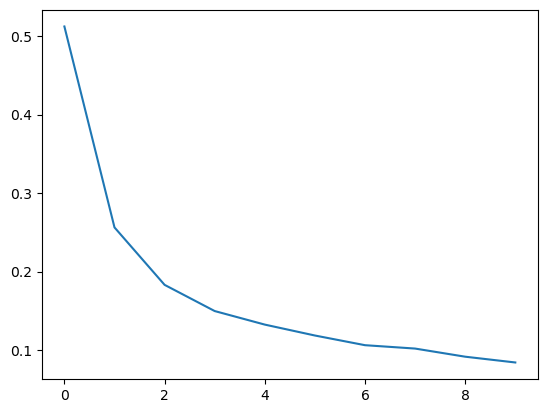

In [36]:
SRC_PATH = "./resources/pneumoniamnist.npz"

with open("./data/generic/config.yml", "r") as f:
    config = yaml.load(f, Loader=yaml.FullLoader)

model = FederatedCNN(
    in_channels=config["model"]["in_channels"],
    num_classes=config["model"]["out_channels"]
)

optimizer = optim.SGD(
    model.parameters(),
    lr=config["hyperparameter"]["learn_rate"],
    momentum=config["hyperparameter"]["momentum"]
)
ce_loss = nn.BCEWithLogitsLoss()

train_dl, val_dl, test_dl = get_dataloaders(
    SRC_PATH,
    batch_size=config["hyperparameter"]["batch_size"],
    train_val_test_split=config["data"]["train_val_test_split"],
    seed=config["data"]["split_seed"]
)

local_train_metrics, local_val_metrics = model.train_model(
    epochs=config["hyperparameter"]["epochs"],
    optimizer=optimizer,
    criterion=ce_loss,
    train_loader=train_dl,
    test_loader=val_dl
)

local_test_metrics = model.test_epoch(
    criterion=ce_loss,
    test_loader=test_dl
)

plt.plot(local_train_metrics["loss"])


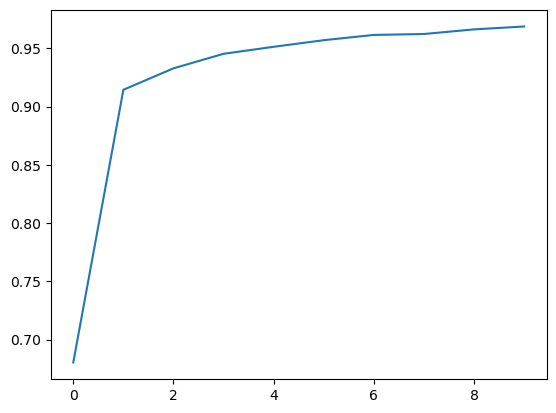

In [37]:
plt.plot(local_train_metrics["acc"])

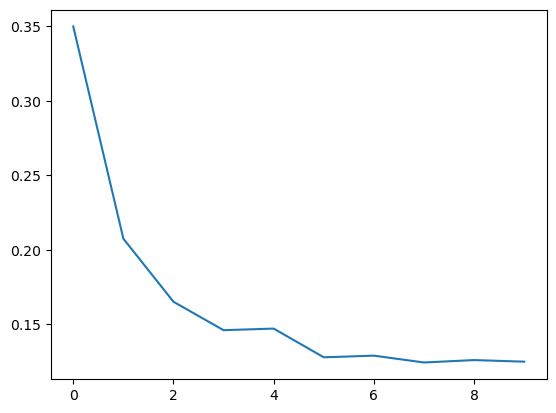

In [38]:
plt.plot(local_val_metrics["loss"])

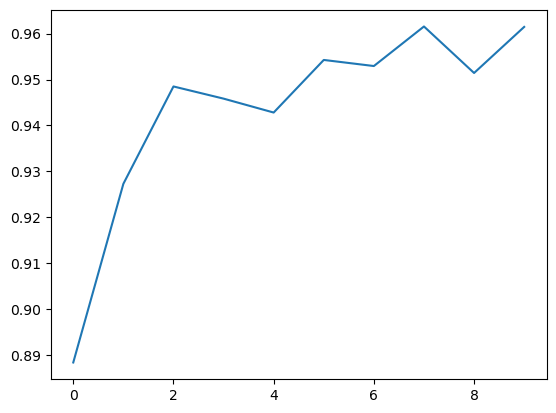

In [39]:
plt.plot(local_val_metrics["acc"])

# Split Data for Federated Learning

In [40]:
import numpy as np
from model.dataset import read_medmnist

SRC_PATH = "./resources/pneumoniamnist.npz"
CLIENTS = 4  # Number of federated clients

data, labels = read_medmnist(SRC_PATH)
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")


Shape of data: (5856, 28, 28) and shape of labels: (5856, 1)


In [41]:
balanced_split = CLIENTS

imbalanced_ratio = (0.2, 0.3, 0.4, 0.1)
imbalanced_split = np.cumsum(np.array(imbalanced_ratio)) * data.shape[0]
imbalanced_split = imbalanced_split.astype(int)
print(imbalanced_split)

l_data, l_labels = np.split(data, imbalanced_split), np.split(labels, imbalanced_split)
print(f"Shape of data: {len(l_data)} and shape of labels: {l_labels[0].shape}")
for client in range(CLIENTS):
    np.savez(f"./resources/pneumoniamnist_client{client}.npz", images=l_data[client], labels=l_labels[client])
    print("saved client data for client", client)

[1171 2928 5270 5856]
Shape of data: 5 and shape of labels: (1171, 1)
saved client data for client 0
saved client data for client 1
saved client data for client 2
saved client data for client 3


In [42]:
data, labels = read_medmnist("./resources/pneumoniamnist_client0.npz")
print(f"Shape of data: {data.shape} and shape of labels: {labels.shape}")

Shape of data: (1171, 28, 28) and shape of labels: (1171, 1)


# Analyze federated model

## Get final model, test, validation and average validation metrics from result files

In [84]:
from collections import defaultdict
import torch
import os
import re
import zipfile
from pathlib import Path

test_no = 10
client_no = [0, 1, 2, 3]



def get_metrics(metrics):
    results = defaultdict(list)
    for m in metrics:
        for k, v in eval(m).items():
            results[k].append(v)
    return results


final_model = None
test_metrics = []
val_metrics = []

# iterate over all files in the directory
result_files = []
path = os.path.abspath("./data/tests")
for file in os.listdir(path):
    if re.search(f"results_test_{test_no}_client_{client_no}_fc_bkim_[0-9]+\.zip", file):
        fp = Path(os.path.join(path, file))
        rp = path + "\\" + fp.stem  # result path
        with zipfile.ZipFile(fp, 'r') as zip_ref:
            zip_ref.extractall(rp)
        for rf in os.listdir(rp):
            if rf == "model.pt":
                final_model = torch.load(os.path.join(rp, rf))
            if rf == "test_metrics.txt":
                with open(os.path.join(rp, rf), "r") as f:
                    test_metrics.append(get_metrics(f.readlines()))
            if rf == "val_metrics.txt":
                with open(os.path.join(rp, rf), "r") as f:
                    val_metrics.append(get_metrics(f.readlines()))

avg_val_metrics = defaultdict(list)
for i in range(len(val_metrics)):
    for k, v in val_metrics[i].items():
        avg_val_metrics[k].append(v)

for k, v in avg_val_metrics.items():
    avg_val_metrics[k] = list(np.mean(v, axis=0))


## Plot metrics

In [85]:
import matplotlib.pyplot as plt

FIGSIZE = (10, 7.5)


def plot_metrics(metric, title=None, save_path=None):
    epochs = np.arange(1, len(avg_val_metrics[metric]) + 1)

    plt.figure(figsize=FIGSIZE)
    if title is None:
        plt.title(metric)
    else:
        plt.title(title)
    plt.xlabel("Epochs")
    plt.xticks(epochs)
    plt.xlim(1, len(epochs)+0.5)
    plt.ylabel(metric)
    plt.ylim(0, max(max(avg_val_metrics[metric]), max(local_val_metrics[metric])) + 0.1)

    for i in range(len(val_metrics)):
        plt.plot(epochs, val_metrics[i][metric], label=f"Client {i}", lw=0.5, linestyle="dashed")

    plt.plot(epochs, avg_val_metrics[metric], label="Client Average", lw=2)
    plt.plot(epochs, local_val_metrics[metric], label="Local Model", lw=2)

    plt.legend()

    if save_path is not None:
        plt.savefig(save_path)

print("Available client val metrics:", list(avg_val_metrics.keys()))
print("Available local val metrics: ", list(local_val_metrics.keys()))


Available client val metrics: ['loss', 'acc', 'auroc', 'recall', 'fnr', 'f1score']
Available local val metrics:  ['loss', 'acc', 'auroc', 'recall', 'fnr', 'f1score']


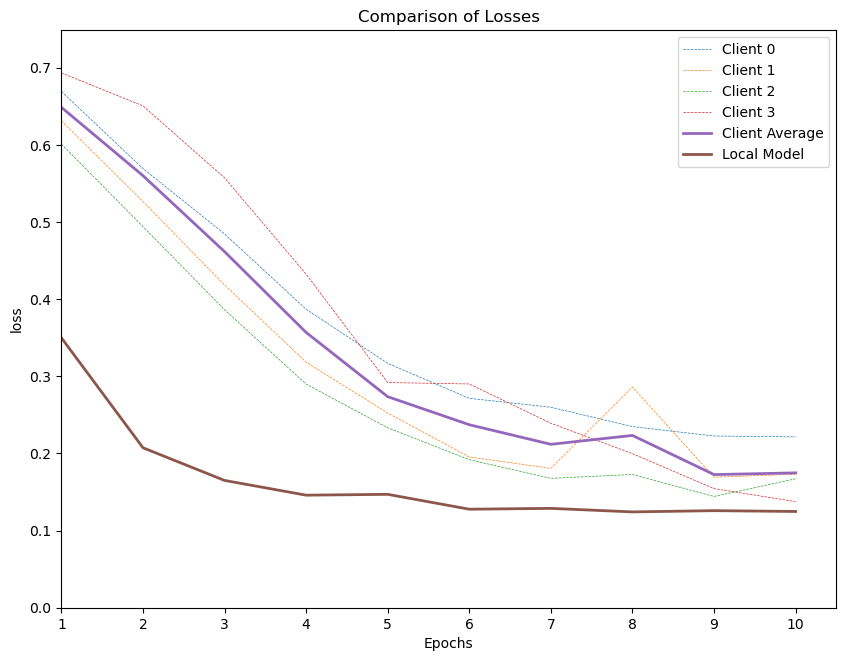

In [86]:
plot_metrics("loss", "Comparison of Losses", save_path="./resources/loss_comparison.png")

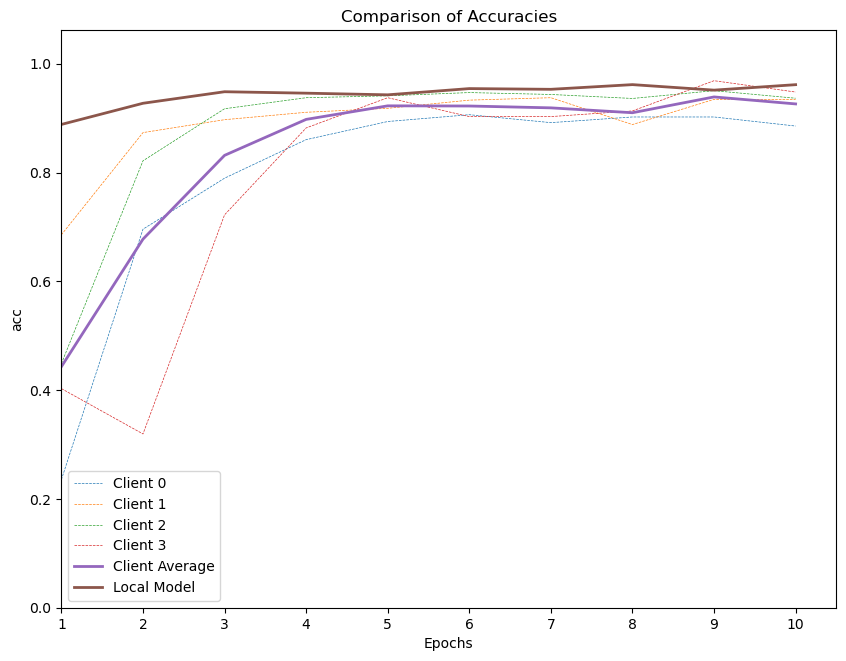

In [87]:
plot_metrics("acc", "Comparison of Accuracies", save_path="./resources/acc_comparison.png")

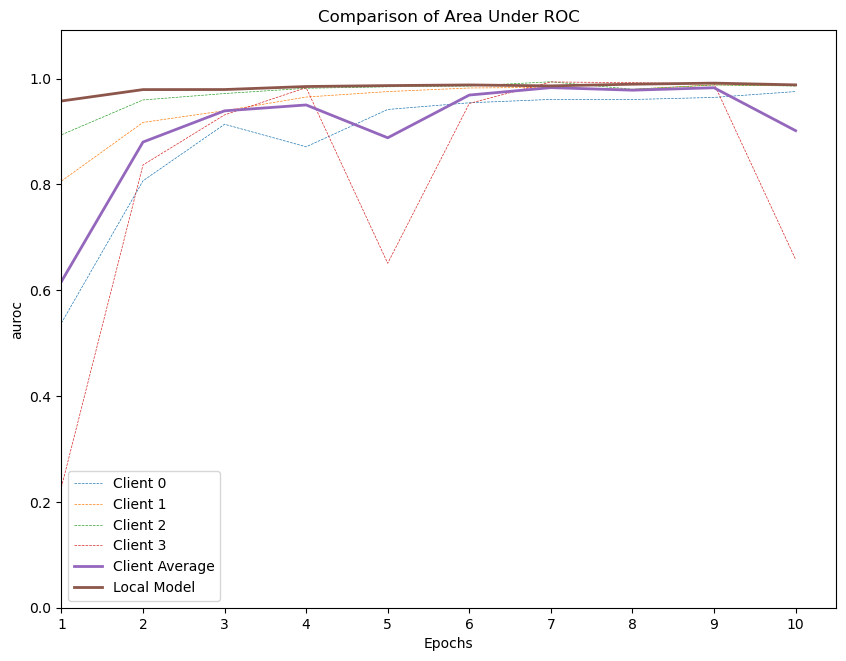

In [88]:
plot_metrics("auroc", "Comparison of Area Under ROC", save_path="./resources/auroc_comparison.png")

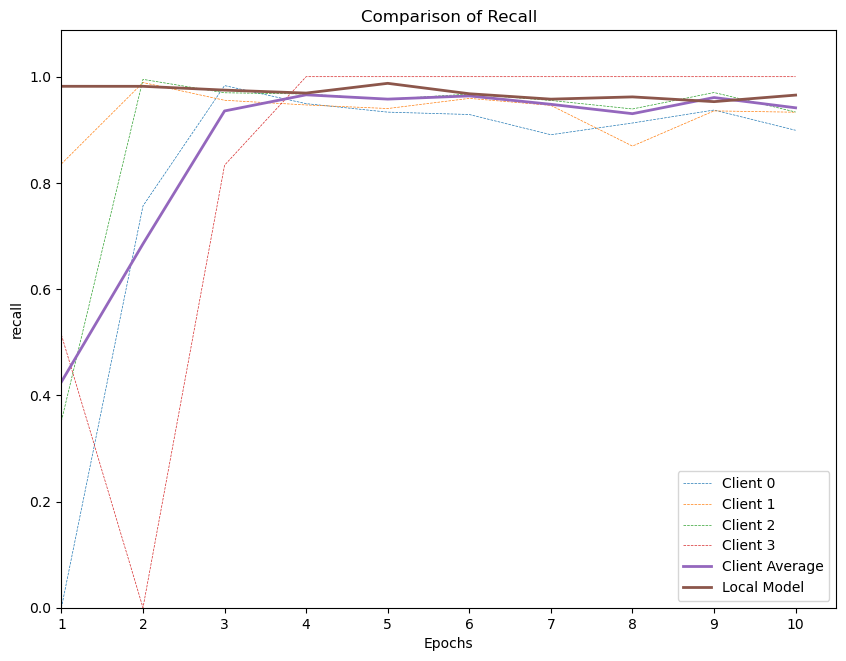

In [89]:
plot_metrics("recall", "Comparison of Recall", save_path="./resources/recall_comparison.png")

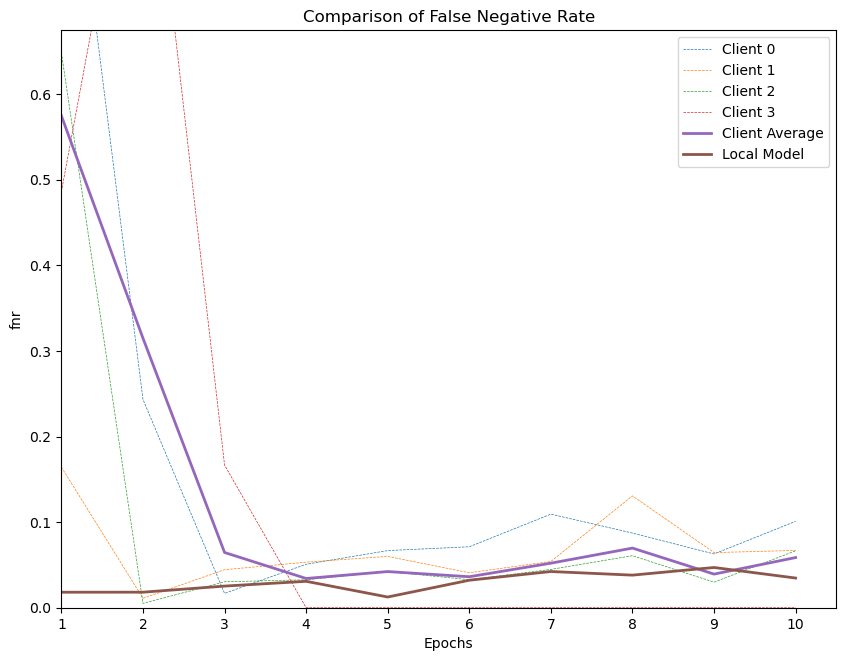

In [90]:
plot_metrics("fnr", "Comparison of False Negative Rate", save_path="./resources/fnr_comparison.png")

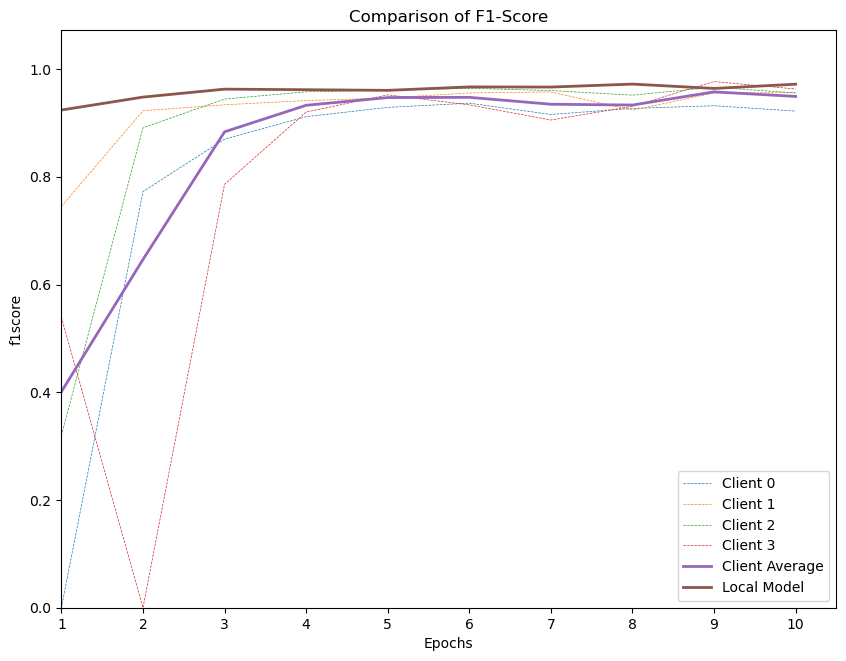

In [91]:
plot_metrics("f1score", "Comparison of F1-Score", save_path="./resources/f1score_comparison.png")

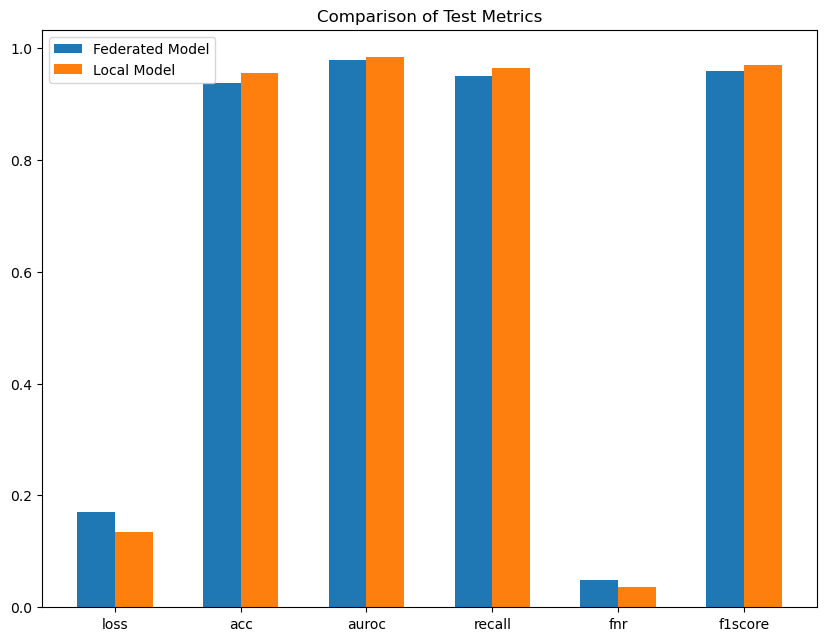

In [92]:
avg_test_metrics = defaultdict(list)
for i in range(len(test_metrics)):
    for k, v in test_metrics[i].items():
        avg_test_metrics[k].append(v[0])

avg_test_metrics = {k: np.mean(v) for k, v in avg_test_metrics.items()}

ind = np.arange(len(avg_test_metrics.keys()))
width = 0.3

plt.figure(figsize=FIGSIZE)

plt.title("Comparison of Test Metrics")
plt.bar(ind, avg_test_metrics.values(), width=width, label="Federated Model")
plt.bar(ind + width, local_test_metrics.values(), width=width, label="Local Model")

plt.xticks(ind + width / 2, avg_test_metrics.keys())

plt.legend()
plt.savefig("./resources/test_metrics_comparison.png")
plt.show()

<BarContainer object of 2 artists>

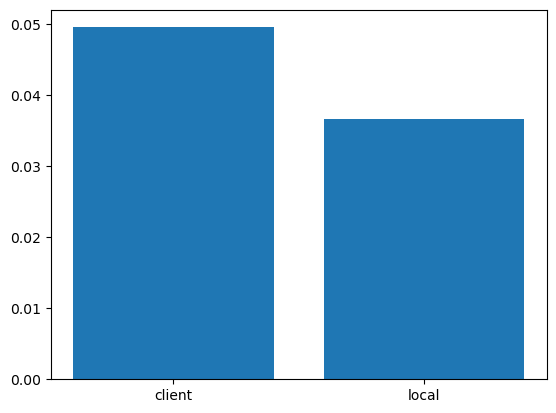

In [93]:
plt.bar(("client", "local"), (avg_test_metrics["fnr"], local_test_metrics["fnr"]))